<a href="https://colab.research.google.com/github/daj10/Skin-Cancer-Segmentation-ISIC2018/blob/main/seg_mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skin Cancer segmentation using Mask-RCNN** ISIC2018

## **Install Mask R-CNN** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from imutils import paths
import argparse
import imutils
import cv2
from imgaug import augmenters as iaa

import warnings
warnings.filterwarnings("ignore")

In [ ]:
cd /content/drive/'MyDrive'/Reconnaissance_Formes

/content/drive/MyDrive/Reconnaissance_Formes


In [ ]:
os.chdir('/content/drive/MyDrive/Reconnaissance_Formes/Mask_RCNN')
os.getcwd()

'/content/drive/MyDrive/Reconnaissance_Formes/Mask_RCNN'

In [ ]:
# project root directory
ROOT_DIR = os.path.abspath("./")

In [ ]:
# installing requirements
!pip3 install -r requirements.txt

In [ ]:
#!pip3 uninstall -y tensorflow
#!pip install tensorflow==1.13.1
import tensorflow
print(tensorflow.__version__)

import keras
print(keras.__version__)
#!pip3 uninstall -y keras
#!pip3 install keras==2.2.4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1
2.2.4


Using TensorFlow backend.


In [ ]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

## **Define paths for weights and images.**

In [ ]:
# directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# downloading COCO trained weights from releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# initialize the dataset path, image path, and annotations file path
DATASET_PATH = os.path.abspath("/content/drive/MyDrive/Reconnaissance_Formes/ISIC2018")
IMAGES_PATH = os.path.sep.join([DATASET_PATH, "Train/images/"])
MASKS_PATH = os.path.sep.join([DATASET_PATH, "Train/masks/"])

# initialize the amount of data to use for training
TRAINING_SPLIT = 0.8

In [ ]:
# grab all image paths, then randomly select indexes for both training
# and validation
IMAGE_PATHS = sorted(list(paths.list_images(IMAGES_PATH)))
idxs = list(range(0, len(IMAGE_PATHS)))
random.seed(42)
random.shuffle(idxs)
i = int(len(idxs) * TRAINING_SPLIT)
trainIdxs = idxs[:i]
valIdxs = idxs[i:]

# initialize the class names dictionary
CLASS_NAMES = {1: "lesion"}

In [ ]:
# initialize the name of the directory where logs and output model
# snapshots will be stored
LOGS_AND_MODEL_DIR = "/content/drive/MyDrive/Reconnaissance_Formes/Mask_RCNN/lesions_logs/"

In [ ]:
class LesionBoundaryConfig(Config):
	# give the configuration a recognizable name
	NAME = "lesion"

	# set the number of GPUs to use training along with the number of
	# images per GPU (which may have to be tuned depending on how
	# much memory your GPU has)
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	# set the number of steps per training epoch and validation cycle
	STEPS_PER_EPOCH = len(trainIdxs)/10 // (IMAGES_PER_GPU * GPU_COUNT)
	VALIDATION_STEPS = len(valIdxs)/10 // (IMAGES_PER_GPU * GPU_COUNT)


	# number of classes (+1 for the background)
	NUM_CLASSES = len(CLASS_NAMES) + 1

class LesionBoundaryInferenceConfig(LesionBoundaryConfig):
	# set the number of GPUs and images per GPU (which may be
	# different values than the ones used for training)
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	# set the minimum detection confidence (used to prune out false
	# positive detections)
	DETECTION_MIN_CONFIDENCE = 0.9

class LesionBoundaryDataset(utils.Dataset):
	def __init__(self, imagePaths, classNames, width=1024):
		# call the parent constructor
		super().__init__(self)

		# store the image paths and class names along with the width
		# we'll resize images to
		self.imagePaths = imagePaths
		self.classNames = classNames
		self.width = width

	def load_lesions(self, idxs):
		# loop over all class names and add each to the 'lesion'
		# dataset
		for (classID, label) in self.classNames.items():
			self.add_class("lesion", classID, label)

		# loop over the image path indexes
		for i in idxs:
			# extract the image filename to serve as the unique
			# image ID
			imagePath = self.imagePaths[i]
			filename = imagePath.split(os.path.sep)[-1]

			# add the image to the dataset
			self.add_image("lesion", image_id=filename,
				path=imagePath)

	def load_image(self, imageID):
		# grab the image path, load it, and convert it from BGR to
		# RGB color channel ordering
		p = self.image_info[imageID]["path"]
		image = cv2.imread(p)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

		# resize the image, preserving the aspect ratio
		image = imutils.resize(image, width=self.width)

		# return the image
		return image

	def load_mask(self, imageID):
		# grab the image info and derive the full annotation path
		# file path
		info = self.image_info[imageID]
		filename = info["id"].split(".")[0]
		annotPath = os.path.sep.join([MASKS_PATH,
			"{}_segmentation.png".format(filename)])

		# load the annotation mask and resize it, *making sure* to
		# use nearest neighbor interpolation
		annotMask = cv2.imread(annotPath)
		annotMask = cv2.split(annotMask)[0]
		annotMask = imutils.resize(annotMask, width=self.width,
			inter=cv2.INTER_NEAREST)
		annotMask[annotMask > 0] = 1

		# determine the number of unique class labels in the mask
		classIDs = np.unique(annotMask)

		# the class ID with value '0' is actually the background
		# which we should ignore and remove from the unique set of
		# class identifiers
		classIDs = np.delete(classIDs, [0])

		# allocate memory for our [height, width, num_instances]
		# array where each "instance" effectively has its own
		# "channel" -- since there is only one lesion per image we
		# know the number of instances is equal to 1
		masks = np.zeros((annotMask.shape[0], annotMask.shape[1], 1),
			dtype="uint8")

		# loop over the class IDs
		for (i, classID) in enumerate(classIDs):
			# construct a mask for *only* the current label
			classMask = np.zeros(annotMask.shape, dtype="uint8")
			classMask[annotMask == classID] = 1

			# store the class mask in the masks array
			masks[:, :, i] = classMask

		# return the mask array and class IDs
		return (masks.astype("bool"), classIDs.astype("int32"))

In [ ]:
# load the training dataset
trainDataset = LesionBoundaryDataset(IMAGE_PATHS, CLASS_NAMES)
trainDataset.load_lesions(trainIdxs)
trainDataset.prepare()

# load the validation dataset
valDataset = LesionBoundaryDataset(IMAGE_PATHS, CLASS_NAMES)
valDataset.load_lesions(valIdxs)
valDataset.prepare()

# initialize the training configuration
config = LesionBoundaryConfig()
config.display()

# initialize the image augmentation process
aug = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5),	iaa.Flipud(0.5),	iaa.Affine(rotate=(-10, 10))])

# initialize the model and load the COCO weights so we can
# perform fine-tuning
model = modellib.MaskRCNN(mode="training", config=config,	model_dir=LOGS_AND_MODEL_DIR)
model.load_weights(COCO_MODEL_PATH, by_name=True,		exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",	"mrcnn_bbox", "mrcnn_mask"])

# train *just* the layer heads
model.train(trainDataset, valDataset, epochs=5, layers="heads", learning_rate=config.LEARNING_RATE,	augmentation=aug)

# unfreeze the body of the network and train *all* layers
model.train(trainDataset, valDataset, epochs=5, layers="all", learning_rate=config.LEARNING_RATE / 10, augmentation=aug)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## **Predict**

In [ ]:
from google.colab.patches import cv2_imshow

Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 5
Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


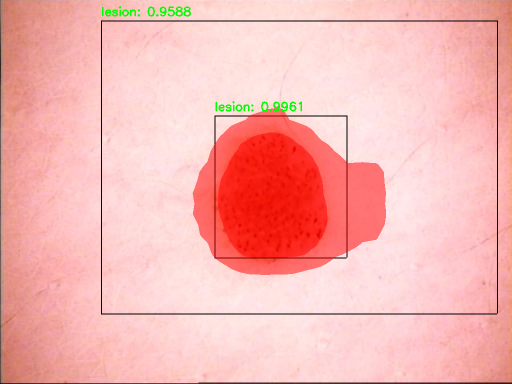

In [ ]:
# initialize the inference configuration
config = LesionBoundaryInferenceConfig()

# initialize the Mask R-CNN model for inference
model = modellib.MaskRCNN(mode="inference", config=config,	model_dir=LOGS_AND_MODEL_DIR)

# load our trained Mask R-CNN
weights = model.find_last()
model.load_weights(weights, by_name=True)

# load the input image, convert it from BGR to RGB channel
# ordering, and resize the image
image_path = "/content/drive/MyDrive/Reconnaissance_Formes/ISIC2018/Test/ISIC_0017069.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=1024)

# perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=1)[0]

# loop over of the detected object's bounding boxes and
# masks, drawing each as we go along
for i in range(0, r["rois"].shape[0]):
	mask = r["masks"][:, :, i]
	image = visualize.apply_mask(image, mask,	(1.0, 0.0, 0.0), alpha=0.5)
	image = visualize.draw_box(image, r["rois"][i],	(1.0, 0.0, 0.0))

# convert the image back to BGR so we can use OpenCV's
# drawing functions
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# loop over the predicted scores and class labels
for i in range(0, len(r["scores"])):
	# extract the bounding box information, class ID, label,
	# and predicted probability from the results
	(startY, startX, endY, end) = r["rois"][i]
	classID = r["class_ids"][i]
	label = CLASS_NAMES[classID]
	score = r["scores"][i]

	# draw the class label and score on the image
	text = "{}: {:.4f}".format(label, score)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# resize the image so it more easily fits on our screen
image = imutils.resize(image, width=512)

# show the output image
cv2_imshow(image)

## **Investigate**

[INFO] image shape: (680, 1024, 3)
[INFO] masks shape: (680, 1024, 1)
[INFO] class IDs length: 1
[INFO] class IDs: [1]
[INFO] investigating image index: 235


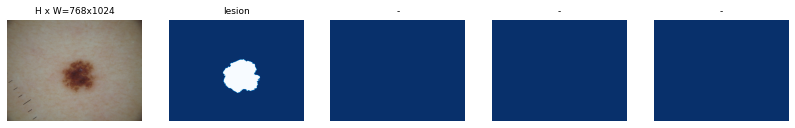

[INFO] investigating image index: 499


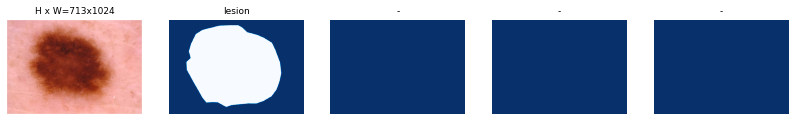

[INFO] investigating image index: 679


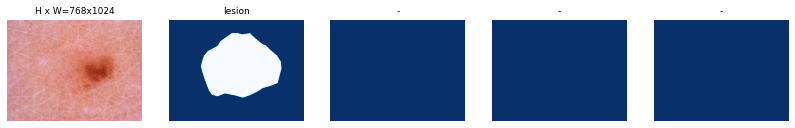

In [ ]:
# load the training dataset
# print(trainIdxs)
trainDataset = LesionBoundaryDataset(IMAGE_PATHS, CLASS_NAMES)
trainDataset.load_lesions(trainIdxs)
trainDataset.prepare()

# load the 0-th training image and corresponding masks
# and class IDs in the masks
image = trainDataset.load_image(0)
(masks, classIDs) = trainDataset.load_mask(0)

# show the image spatial dimensions which is HxWxC
print("[INFO] image shape: {}".format(image.shape))

# show the masks shape which should have the same width and height of
# the image but third dimension should be equal to total number of
# instances in the image itself
print("[INFO] masks shape: {}".format(masks.shape))

# show the length of the class IDs list along with the values inside list
# the length of the list should be equal to the number of instances
# dimension in the masks array
print("[INFO] class IDs length: {}".format(len(classIDs)))
print("[INFO] class IDs: {}".format(classIDs))

# determine a sample of training image indexes and loop over them
for i in np.random.choice(trainDataset.image_ids, 3):
    # load the image and masks for the sampled image
    print("[INFO] investigating image index: {}".format(i))
    image = trainDataset.load_image(i)
    (masks, classIDs) = trainDataset.load_mask(i)

    # visualize the masks for the current image
    visualize.display_top_masks(image, masks, classIDs,
        trainDataset.class_names)